<a href="https://colab.research.google.com/github/wigginno/large-scale-lin-kernighan/blob/main/delaunay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from time import perf_counter, perf_counter_ns

import numpy as np
import numpy.typing as npt
from numba import njit
from matplotlib import pyplot as plt

# using scipy.spatial.Delaunay for comparison
from scipy.spatial import Delaunay

In [ ]:
@njit(cache=True)
def orientation(a, b, c):
    """Determine orientation of c relative to ab.
        - Return value greater than 0 <==> c is to the left of ab
        - Return value less than 0 <==> c is to the right of ab
        - Return value of 0 <==> points {a, b, c} are collinear
    """
    return (a[0] - c[0]) * (b[1] - c[1]) - (a[1] - c[1]) * (b[0] - c[0])

@njit(cache=True)
def dist_squared(a, b):
    """Compute squared Euclidean distance between points a and b."""
    return (a[0] - b[0])**2 + (a[1] - b[1])**2

@njit(cache=True)
def jitter():
    """Return a (negative or positive) random jitter with a magnitude between 1e-12 and 5e-12."""
    jitter = (np.random.rand() - 0.5) * 1e-11
    while abs(jitter) < 1e-12:
        jitter = (np.random.rand() - 0.5) * 1e-11
    return jitter

@njit(cache=True)
def compute_perpendicular_bisector(a: npt.NDArray[np.float64], b: npt.NDArray[np.float64]
                                   ) -> tuple[float, float]:
    """Compute slope and y-intersect of the perpendicular bisector of points a and b."""
    x_diff = (b[0] - a[0]) or jitter()
    y_diff = (a[1] - b[1]) or jitter()
    bisector_slope = x_diff / y_diff
    return bisector_slope, (a[1] + b[1]) / 2 - bisector_slope * (a[0] + b[0]) / 2

@njit(cache=True)
def compute_circumcenter(b: npt.NDArray[np.float64], c: npt.NDArray[np.float64],
                               ab_bisector_slope: float,
                               ab_bisector_intersect: float) -> npt.NDArray[np.float64]:
    bc_bisector_slope, bc_bisector_intersect = compute_perpendicular_bisector(b, c)
    # Jitter if points are collinear
    bisectors_slope_diff = (ab_bisector_slope - bc_bisector_slope) or jitter()
    center_x = (bc_bisector_intersect - ab_bisector_intersect) / bisectors_slope_diff
    return np.array([center_x, center_x * ab_bisector_slope + ab_bisector_intersect],
                    dtype=np.float64)

@njit(cache=True)
def compute_perpendicular_bisector_vector(a: np.ndarray[np.float64], b: np.ndarray[np.float64]):
    dx = a[0] - b[0]
    dy = a[1] - b[1]
    ab_chord_length = np.sqrt(dx**2 + dy**2)
    x_component = -dy / ab_chord_length
    y_component = dx / ab_chord_length
    return np.array([x_component, y_component], dtype=np.float64)

In [ ]:
@njit(cache=True)
def compare_points(a, b, p) -> bool:
    """Comparison function to sort points for Graham's scan."""
    ap_dx = a[0] - p[0]
    ap_dy = a[1] - p[1]
    bp_dx = b[0] - p[0]
    bp_dy = b[1] - p[1]

    if ap_dy == 0 and bp_dy == 0:
        return a[0] < b[0]

    if ap_dy == 0:
        return True

    if bp_dy == 0:
        return False

    ap_inverse_slope = ap_dx / ap_dy
    bp_inverse_slope = bp_dx / bp_dy

    return ap_inverse_slope > bp_inverse_slope

@njit(cache=True)
def merge(A, Aux, lo, mid, hi, points, lowest_point):
    """Adapted from:
        https://github.com/aetperf/aetperf.github.io/blob/master/_posts/2020-12-30-Merge-Sort-with-Cython-and-Numba.md
    """
    i = lo
    j = mid + 1
    for k in range(lo, hi + 1):
        if i > mid:
            Aux[k] = A[j]
            j += 1
        elif j > hi:
            Aux[k] = A[i]
            i += 1
        elif compare_points(points[A[j]], points[A[i]], lowest_point):
            Aux[k] = A[j]
            j += 1
        else:
            Aux[k] = A[i]
            i += 1

@njit(cache=True)
def insertion_sort(A, lo, hi, points, lowest_point):
    """Adapted from:
        https://github.com/aetperf/aetperf.github.io/blob/master/_posts/2020-12-30-Merge-Sort-with-Cython-and-Numba.md
    """
    for i in range(lo + 1, hi + 1):
        key = A[i]
        j = i - 1
        while (j >= lo) & compare_points(points[key], points[A[j]], lowest_point):
            A[j + 1] = A[j]
            j -= 1
        A[j + 1] = key

@njit(cache=True)
def merge_sort(A, Aux, lo, hi, points, lowest_point):
    """Adapted from:
        https://github.com/aetperf/aetperf.github.io/blob/master/_posts/2020-12-30-Merge-Sort-with-Cython-and-Numba.md
    """
    if hi - lo > 40:
        mid = lo + ((hi - lo) >> 1)
        merge_sort(Aux, A, lo, mid, points, lowest_point)
        merge_sort(Aux, A, mid + 1, hi, points, lowest_point)
        if compare_points(points[A[mid + 1]], points[A[mid]], lowest_point):
            merge(A, Aux, lo, mid, hi, points, lowest_point)
        else:
            for i in range(lo, hi + 1):
                Aux[i] = A[i]
    else:
        insertion_sort(Aux, lo, hi, points, lowest_point)

@njit(cache=True)
def graham_scan_sort(points, lowest_point):
    """Adapted from:
        https://github.com/aetperf/aetperf.github.io/blob/master/_posts/2020-12-30-Merge-Sort-with-Cython-and-Numba.md
    """
    A = np.arange(len(points), dtype=np.int32)
    Aux = np.copy(A)
    merge_sort(Aux, A, 0, len(A) - 1, points, lowest_point)
    return A

@njit(cache=True)
def graham_scan(points: np.ndarray):
    """ Perform Graham's scan and return the convex hull. """
    lowest_p_index = np.argmin(points[:, 1])

    # Sort points by polar angle made with lowest point.
    sorted_indices = graham_scan_sort(points, points[lowest_p_index])

    stack = [lowest_p_index]
    for i in sorted_indices:
        if i == lowest_p_index:
            continue
        while len(stack) > 1 and orientation(points[stack[-2]], points[stack[-1]], points[i]) < 0:
            stack.pop()
        stack.append(i)

    return np.array(stack, dtype=np.int32)

@njit(cache=True)
def compute_convex_hull_mask(points):
    convhull = graham_scan(points)
    convhull_mask = np.zeros(len(points), dtype=np.bool_)
    convhull_mask[convhull] = True
    return convhull_mask

In [ ]:
@njit(cache=True)
def build_2d_tree(points, point_indices, tree, depth):
    points_sort_idx = np.argsort(points[:, depth % 2])
    points = points[points_sort_idx]
    point_indices = point_indices[points_sort_idx]
    mid = len(points) // 2
    point_indices_left = point_indices[:mid]
    point_indices_left = point_indices[:mid]
    point_indices_right = point_indices[(mid + 1):]
    points_left = points[:mid]
    points_right = points[(mid + 1):]

    p = point_indices[mid]

    max_depth = depth

    if len(points_left) > 0:
        child_p, child_depth = build_2d_tree(points_left, point_indices_left, tree, depth + 1)
        max_depth = child_depth
        tree[p][0] = child_p

    if len(points_right) > 0:
        child_p, child_depth = build_2d_tree(points_right, point_indices_right, tree, depth + 1)
        max_depth = max(max_depth, child_depth)
        tree[p][1] = child_p

    return p, max_depth

@njit(cache=True)
def kdtree_2d(points):
    n_points = len(points)
    tree = np.empty((n_points, 2), dtype=np.int32)
    tree[:, 0] = np.arange(n_points)
    tree[:, 1] = np.arange(n_points)

    root, max_depth = build_2d_tree(points, np.arange(len(points)), tree, 0)

    return tree, root, max_depth

@njit(cache=True)
def find_vertex_approx(tree: npt.NDArray[np.int32], root: int, query_point: npt.NDArray,
                       points: npt.NDArray[np.float64], point_a: npt.NDArray[np.float64],
                       point_b: npt.NDArray[np.float64], orientation_sign: int,
                       point_stack: npt.NDArray[np.int32], depth_stack: npt.NDArray[np.int32],
                       diff_stack: npt.NDArray[np.float64]) -> int:
    best_point = 0
    best_dist = np.inf
    point_stack[0] = root
    depth_stack[0] = 0
    diff_stack[0] = np.inf
    top = 0

    while top != -1:
        p_idx = point_stack[top]
        depth = depth_stack[top]
        diff = diff_stack[top]
        top -= 1

        if diff != np.inf and diff**2 >= best_dist:
            continue

        p = points[p_idx]

        if orientation(point_a, point_b, p) * orientation_sign > 0:
            distance = dist_squared(p, query_point)
            if distance < best_dist:
                best_point = p_idx
                best_dist = distance

        axis = depth % 2
        diff = query_point[axis] - p[axis]

        if diff > 0:
            search_now, search_later = tree[p_idx][1], tree[p_idx][0]
        else:
            search_now, search_later = tree[p_idx][0], tree[p_idx][1]

        if search_later != p_idx:
            top += 1
            point_stack[top] = search_later
            depth_stack[top] = depth + 1
            diff_stack[top] = diff

        if search_now != p_idx:
            top += 1
            point_stack[top] = search_now
            depth_stack[top] = depth + 1
            diff_stack[top] = np.inf

    return best_point

@njit(cache=True)
def find_vertex(tree: npt.NDArray, root: int, a: int, b: int, c: int, points: npt.NDArray,
                point_stack: npt.NDArray[np.int32], depth_stack: npt.NDArray[np.int32],
                diff_stack: npt.NDArray[np.float64]) -> tuple[int, npt.NDArray, float]:
    point_a = points[a]
    point_b = points[b]
    point_c = points[c]

    comp = compute_perpendicular_bisector_vector(point_a, point_b)
    orientation_sign = -1 if (orientation(point_a, point_b, point_c) > 0) else 1
    comp *= -orientation_sign

    ab_bisector_slope, ab_bisector_intersect = compute_perpendicular_bisector(point_a, point_b)
    abc_center = compute_circumcenter(point_b, point_c, ab_bisector_slope, ab_bisector_intersect)
    abc_radius_squared = dist_squared(point_a, abc_center)

    initial_query_point = abc_center + comp * np.sqrt(abc_radius_squared)
    initial_point = find_vertex_approx(tree, root, initial_query_point, points, point_a, point_b,
                                       orientation_sign, point_stack, depth_stack, diff_stack)

    query_point = compute_circumcenter(point_b, points[initial_point],
                                       ab_bisector_slope, ab_bisector_intersect)
    best_point = initial_point
    best_dist = dist_squared(query_point, point_a)

    point_stack[0] = root
    depth_stack[0] = 0
    diff_stack[0] = np.inf
    top = 0

    while top != -1:
        p_idx = point_stack[top]
        depth = depth_stack[top]
        diff = diff_stack[top]
        top -= 1

        if diff != np.inf and (query_point[(depth + 1) % 2] - diff)**2 >= best_dist:
            continue

        p = points[p_idx]

        if orientation(point_a, point_b, p) * orientation_sign > 0:
            distance = dist_squared(p, query_point)
            if distance < best_dist:
                center = compute_circumcenter(point_b, p, ab_bisector_slope, ab_bisector_intersect)
                r2 = dist_squared(center, p)
                best_point = p_idx
                best_dist = r2
                query_point = center

        axis = depth % 2
        diff = query_point[axis] - p[axis]

        if diff > 0:
            search_now, search_later = tree[p_idx][1], tree[p_idx][0]
        else:
            search_now, search_later = tree[p_idx][0], tree[p_idx][1]

        if search_later != p_idx:
            top += 1
            point_stack[top] = search_later
            depth_stack[top] = depth + 1
            diff_stack[top] = p[axis]

        if search_now != p_idx:
            top += 1
            point_stack[top] = search_now
            depth_stack[top] = depth + 1
            diff_stack[top] = np.inf

    return best_point

In [ ]:
@njit(cache=True)
def find_initial_triangle(points: npt.NDArray[np.float64]):
    v2, v3 = 0, 0

    min_distance = np.inf
    for i in range(1, len(points)):
        distance = dist_squared(points[0], points[i])
        if distance < min_distance:
            min_distance = distance
            v2 = i

    bisect_slope, bisect_intersect = compute_perpendicular_bisector(points[0], points[v2])

    min_radius_squared = np.inf
    for i in range(1, len(points)):
        if i == v2:
            continue
        circumcenter = compute_circumcenter(points[v2], points[i], bisect_slope, bisect_intersect)
        radius_squared = dist_squared(points[0], circumcenter)
        if radius_squared < min_radius_squared:
            min_radius_squared = radius_squared
            v3 = i

    return (0, v2, v3) if v2 < v3 else (0, v3, v2)

@njit(cache=True)
def triangulate(points: npt.NDArray[np.float64]):
    convex_hull_mask = compute_convex_hull_mask(points)
    tree, root, max_depth = kdtree_2d(points)
    stack_size = max_depth + 1
    point_stack = np.empty(stack_size, dtype=np.int32)
    depth_stack = np.empty(stack_size, dtype=np.int32)
    diff_stack = np.empty(stack_size, dtype=np.float64)

    edges_todo = {}
    triangles = np.empty((len(points) * 2, 3), dtype=np.int32)

    # Initial triangle
    a, b, c = find_initial_triangle(points)

    edges_todo[(a, b)] = c
    edges_todo[(b, c)] = a
    edges_todo[(a, c)] = b

    triangles[0] = a, b, c

    triangle_index = 1
    while len(edges_todo) != 0:
        (a, b), c = edges_todo.popitem()
        d = find_vertex(tree, root, a, b, c, points, point_stack, depth_stack, diff_stack)
        edge_ad = (a, d) if a < d else (d, a)
        edge_bd = (b, d) if b < d else (d, b)
        if edge_ad in edges_todo:
            del edges_todo[edge_ad]
        elif ((not convex_hull_mask[a]) or (not convex_hull_mask[d])):
            edges_todo[edge_ad] = b
        if edge_bd in edges_todo:
            del edges_todo[edge_bd]
        elif ((not convex_hull_mask[b]) or (not convex_hull_mask[d])):
            edges_todo[edge_bd] = a
        triangles[triangle_index] = a, b, d
        triangle_index += 1

    return triangles[:triangle_index]

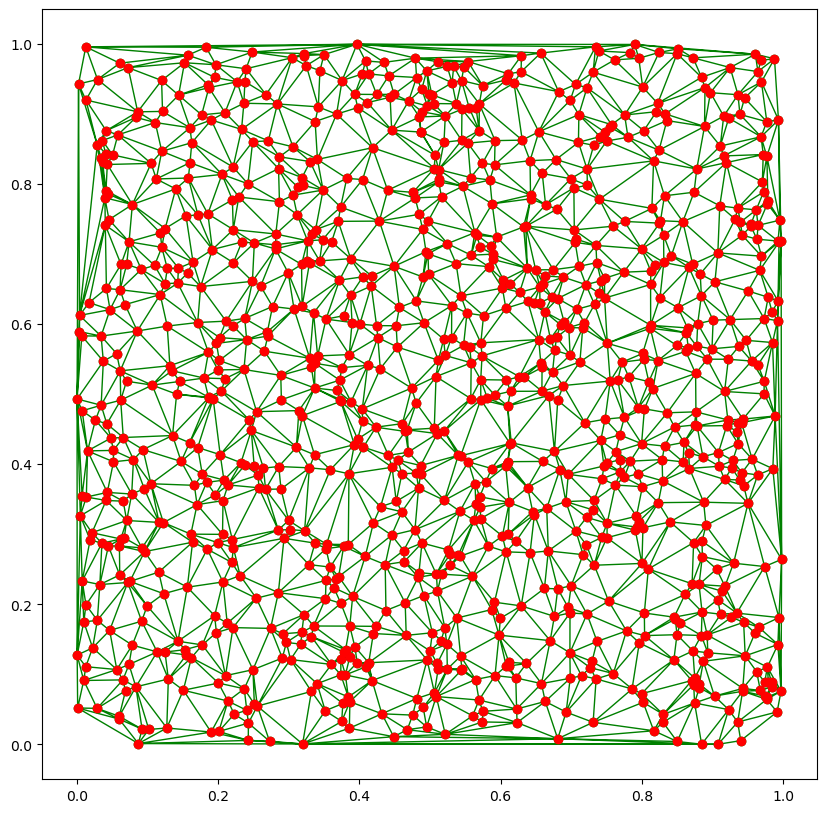

In [ ]:
### Warm up numba and plot 1000-point mesh
points_1k = np.random.rand(1000, 2)
tri = triangulate(points_1k)
plt.figure(figsize=(10, 10))
plt.triplot(points_1k[:, 0], points_1k[:, 1], tri, 'go-', lw=1)
plt.plot(points_1k[:, 0], points_1k[:, 1], 'ro')
plt.show()

In [ ]:
### Benchmark: Triangulate 1 million points, compare with scipy.spatial.Delaunay

points_1m = np.random.rand(1000000, 2)
st = perf_counter()
tri = triangulate(points_1m)
et = perf_counter()
print(f"Time to triangulate 1M points (my algorithm/implementation): {(et - st):.2f} s")

st = perf_counter()
tri2 = Delaunay(points_1m).simplices
et = perf_counter()
print(f"Time to triangulate 1M points (scipy): {(et - st):.2f} s")

tri_set_1 = {tuple(sorted(t)) for t in tri}
tri_set_2 = {tuple(sorted(t)) for t in tri2}

assert(tri_set_1 == tri_set_2), "Triangulations do not match."
print("Triangulations match.")

Time to triangulate 1M points (my algorithm/implementation): 5.78 s
Time to triangulate 1M points (scipy): 7.43 s
Triangulations match.
